# Fourth experiment
## Convolutional neural network (lenet), fashion-mnist


In this experiment we are going to test the robustness of neural networks in a very basic configuration, using Activation Function in the hidden layer as a changing parameter.
The constant characteristics of the networks are:
* Dataset = fashion-mnist
* Loss = cathegorical crossentropy
* Output activation = softmax
* Number of hidden layers = 1
* Early stopping metric =  val_loss with patience 10

After having our models correctly set up, we are going to attack them and measure their robustness according to some metrics (before and after attack):
* Accuracy
* Precision
* Recall
* Max and min confidence
* Confusion matrix
* Most and least robust class


## Imports

In [12]:
import matplotlib
import matplotlib.pyplot as plt
from functions import *
import time
import gc
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib.colors import LinearSegmentedColormap

## Model

### Data Load and Preprocessing

In [2]:
# load data
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print("Train set: ", train_images.shape)
print("Test set: ", test_images.shape)

# divide data into classes
subsets = []
n_classes = 10
for i in range(n_classes):
    tmp_list = []
    for j in range(test_images.shape[0]):
        c = np.nonzero(test_labels[j])[0][0]
        if c == i:
            tmp_list.append(test_images[j])
    tmp_list = np.array(tmp_list)
    subsets.append(tmp_list)
# now we have subsets which is a 10-elements list containing arrays of same class images

new_test_images = np.zeros((0,28,28))
for i in range(len(subsets)):
    new_test_images = np.concatenate((new_test_images, subsets[i]))
# now we have new_test_images which is test_images sorted by class

new_test_labels = np.zeros((0,10))
for i in range(len(subsets)):
    tmp = np.zeros((subsets[i].shape[0],10))
    tmp[:,i] = 1
    new_test_labels = np.concatenate((new_test_labels, tmp))
# now we have new_test_labels which is test_labels sorted to fit subsets

Train set:  (60000, 28, 28)
Test set:  (10000, 28, 28)


### Build and Train Models

In [ ]:

x = tf.reshape(train_images, shape=[-1, 28, 28, 1])

for function, initializer in DEEP_ACTIVATION.items():


    input_layer = tf.keras.layers.Input(shape=(28,28,1), name='input')
    conv1_layer = tf.keras.layers.Conv2D(16, (3,3), activation=function, name='conv1')(input_layer)
    dropout1_layer = tf.keras.layers.Dropout(0.2)(conv1_layer)
    maxpool1_layer = tf.keras.layers.MaxPool2D((2,2))(dropout1_layer)
    conv2_layer = tf.keras.layers.Conv2D(32, (3,3), activation=function, name='conv2')(maxpool1_layer)
    dropout2_layer = tf.keras.layers.Dropout(0.2)(conv2_layer)
    maxpool2_layer = tf.keras.layers.MaxPool2D((2,2))(dropout2_layer)
    conv3_layer = tf.keras.layers.Conv2D(64, (3,3), activation=function, name='conv3')(maxpool2_layer)
    dropout3_layer = tf.keras.layers.Dropout(0.2)(conv3_layer)
    maxpool3_layer = tf.keras.layers.MaxPool2D((2,2))(dropout3_layer)
    flatten_layer = tf.keras.layers.Flatten()(maxpool3_layer)
    dense_layer = tf.keras.layers.Dense(64, activation=function, kernel_initializer=initializer)(flatten_layer)
    output_layer = tf.keras.layers.Dense(10, activation='softmax')(dense_layer)

    network = tf.keras.models.Model(inputs=[input_layer], outputs=[output_layer])

    #Model Summary
    network.summary()

    network.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

    print(f'Network training with ativation function = "{function}"')

    es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=ES_PATIENCE)
    path = MODELS_PATH+"/best_" + function + ".h5"
    mc = ModelCheckpoint(filepath=path, monitor="val_loss", mode="min", save_best_only=True)
    cb_list = [es, mc]

    h = network.fit(x,train_labels,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=VALIDATION_SPLIT,callbacks=cb_list)

    # At this point we have best models saved in "best_models" folder

### Model Metrics Evaluation

In [ ]:
for function, initializer in DEEP_ACTIVATION.items():
    print(f'Evaluate model with hidden activation function "{function}"...')
    name = MODELS_PATH+"/best_" + function + ".h5"
    model = load_model(name)
    metrics_name = "scores_best_"+function
    x = tf.reshape(new_test_images, shape=[-1, 28, 28, 1])
    m = ModelMetrics(metrics_name, new_test_images, new_test_labels, model.predict(x))
    m.buil_metrics()
    path = SCORES_PATH+"/"+metrics_name
    save_object(m, path)

## Attack

The attack consists of these steps:
1. select the model
2. take the test set and, for each class, find the most vulnerable pixel and the corresponding value (i.e. x,y,z)
3. modify the entire test set changing the pixel values found in the previous step
4. evaluate all the metrics of the selected model with the modified test set


### Prepare Attack

In [3]:
def objective(trial, m, test, current_class):

    xp = trial.suggest_int("xp", MIN_XP, MAX_XP)
    yp = trial.suggest_int("yp", MIN_YP, MAX_XP)
    value = trial.suggest_uniform("zp", MIN_ZP, MAX_ZP)

    new_test_labels = np.zeros((test.shape[0],10))
    new_test_labels[:,current_class] = 1

    tmp = np.copy(test)
    tmp[:,xp,yp] = value
    x = tf.reshape(tmp, shape=[-1, 28, 28, 1])

    # minimize loss

    return m.evaluate(x,new_test_labels, verbose=0)[1]

def print_best_callback(study, trial):
    print(f"#Trial: {trial.number}, Best value: {study.best_value}, Best params: {study.best_trial.params}")

### Perform Attack

In [ ]:
start_time = time.time()

for function, initializer in DEEP_ACTIVATION.items(): # 7
    model_name = MODELS_PATH+"/best_" + function + ".h5"
    model = load_model(model_name)
    new_attacked_test_images = np.zeros((0,28,28))
    for i in CLASS_NAMES: # 10

        if not VERBOSITY:
            optuna.logging.set_verbosity(optuna.logging.WARNING)

        func = lambda trial: objective(trial, model, subsets[i], i)

        study_name = f"study_{function}_{i}"
        storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
        study = optuna.create_study(study_name=study_name, storage=storage_name,direction=DIRECTION, sampler=SAMPLER)
        # study.optimize(func, n_trials=N_TRIALS, timeout=TIMEOUT, callbacks=[print_best_callback])
        study.optimize(func, n_trials=N_TRIALS, callbacks=[print_best_callback])

print("--- %s seconds ---" % (time.time() - start_time))
# 2048 =  seconds =  hours

### Visualize Attack

#### Data preparation

In [ ]:
for function, initializer in DEEP_ACTIVATION.items():
    accuracy_trend = {0:load_object(SCORES_PATH+"/scores_best_"+function).accuracy}
    for c in range(N_CHECKPOINTS):
        attacked_test_images = np.zeros((0,28,28))
        count = (c+1)*int((N_TRIALS/N_CHECKPOINTS))
        for i in CLASS_NAMES:
            study_name = f"study_{function}_{i}"
            storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
            study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
            df = study.trials_dataframe(attrs=("value", "params"))
            idx = df['value'].head(count).idxmin()
            xp = df['params_xp'][idx]
            yp = df['params_yp'][idx]
            zp = df['params_zp'][idx]

            sub_attacked_test_images = np.copy(subsets[i])
            sub_attacked_test_images[:,xp,yp] = zp
            attacked_test_images = np.concatenate((attacked_test_images, sub_attacked_test_images))
        # here we have attacked_test_images correctly built
        metrics_name = "acc_trend_"+function
        name = MODELS_PATH+"/best_" + function + ".h5"
        model = load_model(name)
        x = tf.reshape(attacked_test_images, shape=[-1, 28, 28, 1])
        m = ModelMetrics(metrics_name, x, new_test_labels, model.predict(x))
        m.buil_metrics()
        if c==(N_CHECKPOINTS-1):
            path = SCORES_PATH+"/scores_best_"+function+"_best_attack"
            save_object(m, path)
        accuracy_trend[count] = m.accuracy
        del m
        gc.collect()
    path = SCORES_PATH+"/"+metrics_name
    save_object(accuracy_trend, path)
    # here we have saved attacked models metrics for each checkpoint for one function

#### Table "functions vs classes" of attack surface (objective function value)

In [ ]:
plt.rcParams["figure.figsize"] = (10, 8)
for function, initializer in DEEP_ACTIVATION.items():
    for i in CLASS_NAMES:
        study_name = f"study_{function}_{i}"
        storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
        study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
        fig = optuna.visualization.matplotlib.plot_contour(study, params=['xp', 'yp'], target_name='')
        fig.invert_yaxis()
        fig.set_title(f"Function="+r"$\bf{" + function + "}$"+", Class="+r"$\bf{" + CLASS_NAMES[i] + "}$", fontsize=20)
        path = f"{ATTACK_SURFACE_F_FIG_PATH}/attack_surface_f_{function}_{i}.png"
        plt.savefig(path)

#### Table "functions vs classes" of attack surface (modified pixel value)

In [ ]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["cyan","black","white"])


for function, initializer in DEEP_ACTIVATION.items():
    for i in CLASS_NAMES:

        study_name = f"study_{function}_{i}"
        storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
        study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
        df = study.trials_dataframe(attrs=("value", "params"))
        df = df.groupby(['params_xp','params_yp', 'params_zp'], as_index=False)['value'].min()
        df = df.groupby(['params_xp','params_yp', ], as_index=False)['params_zp'].min()

        data1 = np.ones((28,28)) * -1
        for index, row in df.iterrows():
            data1[int(row['params_xp']),int(row['params_yp'])] = row['params_zp']

        data2 = np.mean(np.array(subsets[i]),axis=0)

        fig, (ax, ax2, cax) = plt.subplots(ncols=3,figsize=(10,6),gridspec_kw={"width_ratios":[1,1, 0.05]})
        fig.subplots_adjust(wspace=0.3)
        im  = ax.imshow(data1, vmin=-1, vmax=1, cmap=cmap)
        im2 = ax2.imshow(data2, vmin=-1, vmax=1, cmap=cmap)
        ax.set_ylabel("yp")
        ax.set_xlabel("xp")
        ax2.set_xlabel("xp")
        ip = InsetPosition(ax2, [1.05,0,0.05,1])
        cax.set_axes_locator(ip)
        fig.colorbar(im, cax=cax, ax=[ax,ax2])
        fig.suptitle(f"Function="+r"$\bf{" + function + "}$"+", Class="+r"$\bf{" + CLASS_NAMES[i] + "}$", fontsize=20)

        path = f"{ATTACK_SURFACE_Z_FIG_PATH}/attack_surface_z_{function}_{i}.png"
        fig.savefig(path)

#### Accuracy trend for each function

base-model accuracy:0.7867
2048-optuna-iterations-model accuracy:0.6579
difference:0.1288


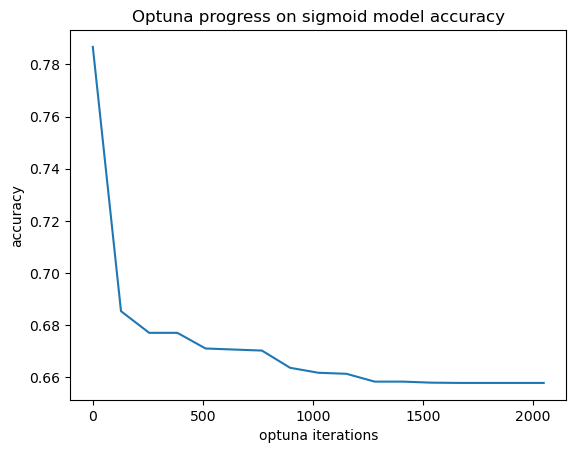

base-model accuracy:0.8491
2048-optuna-iterations-model accuracy:0.7848
difference:0.0643


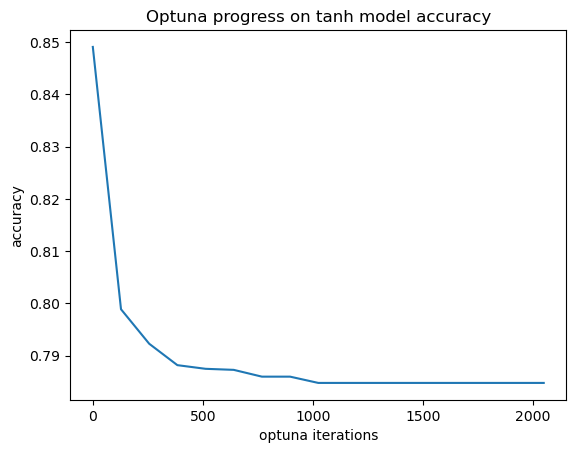

base-model accuracy:0.8644
2048-optuna-iterations-model accuracy:0.8046
difference:0.0598


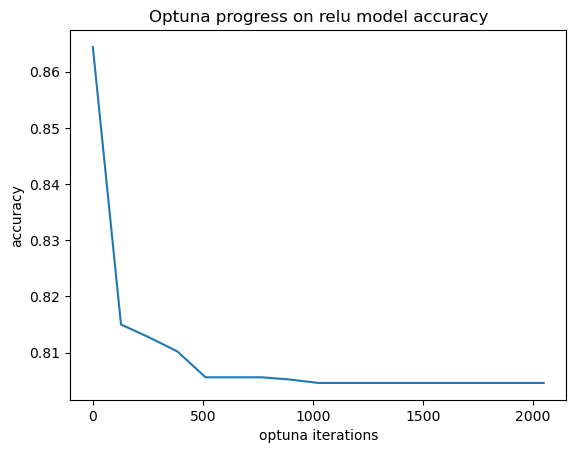

base-model accuracy:0.8554
2048-optuna-iterations-model accuracy:0.7708
difference:0.0846


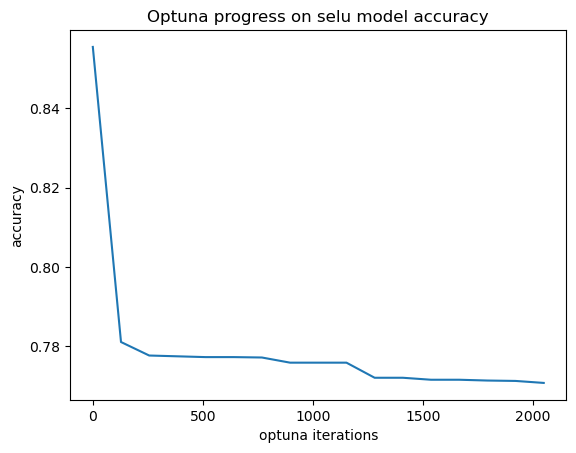

base-model accuracy:0.8489
2048-optuna-iterations-model accuracy:0.7493
difference:0.0996


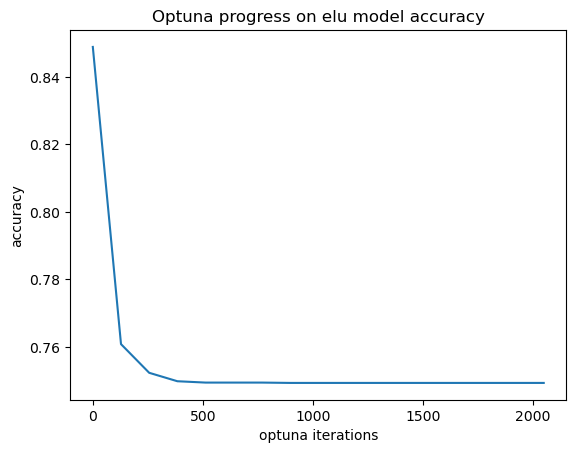

base-model accuracy:0.8358
2048-optuna-iterations-model accuracy:0.7942
difference:0.0416


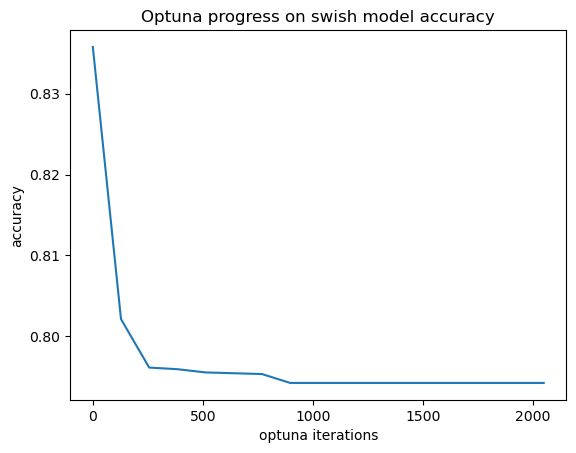

In [2]:
for function, initializer in DEEP_ACTIVATION.items():
    d = load_object(f"./scores/acc_trend_{function}")
    keys = np.fromiter(d.keys(), dtype=int)
    vals = np.fromiter(d.values(), dtype=float)
    print(f"base-model accuracy:{vals[0]}\n2048-optuna-iterations-model accuracy:{vals[-1]}\ndifference:%.4f" % (vals[0]-vals[-1]))

    plt.plot(keys, vals, label = "line 1")
    plt.title(f'Optuna progress on {function} model accuracy')
    plt.xlabel('optuna iterations')
    plt.ylabel('accuracy')
    plt.show()

#### Best attack for each function

index=5225 value=0.8209682703018188


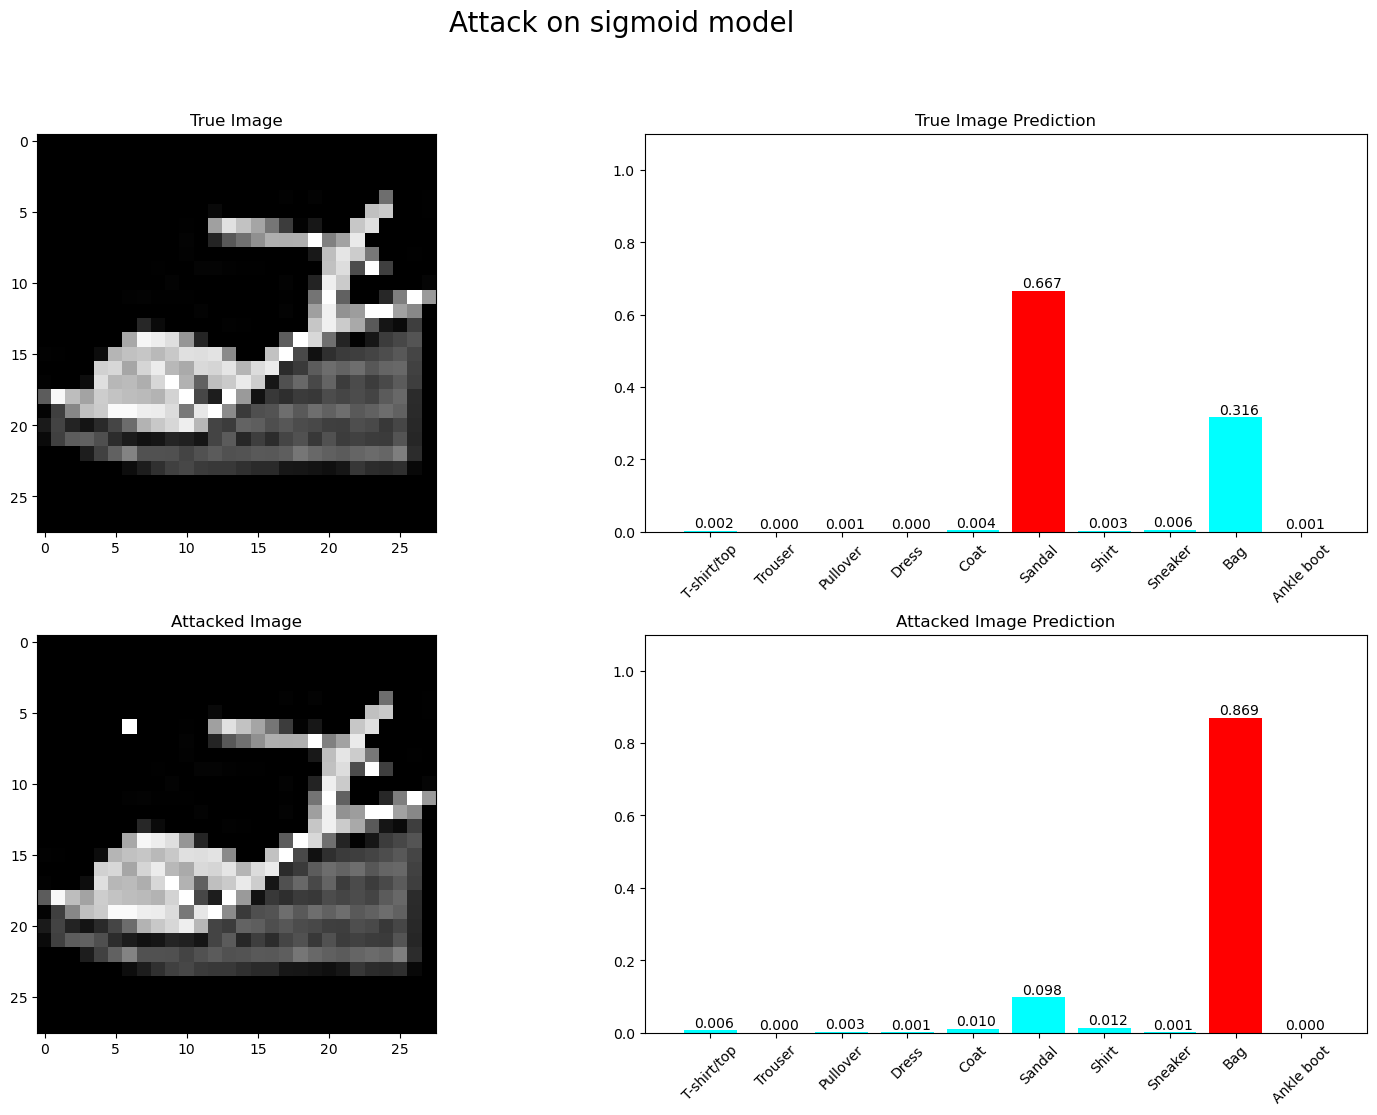

index=5012 value=0.8116092681884766


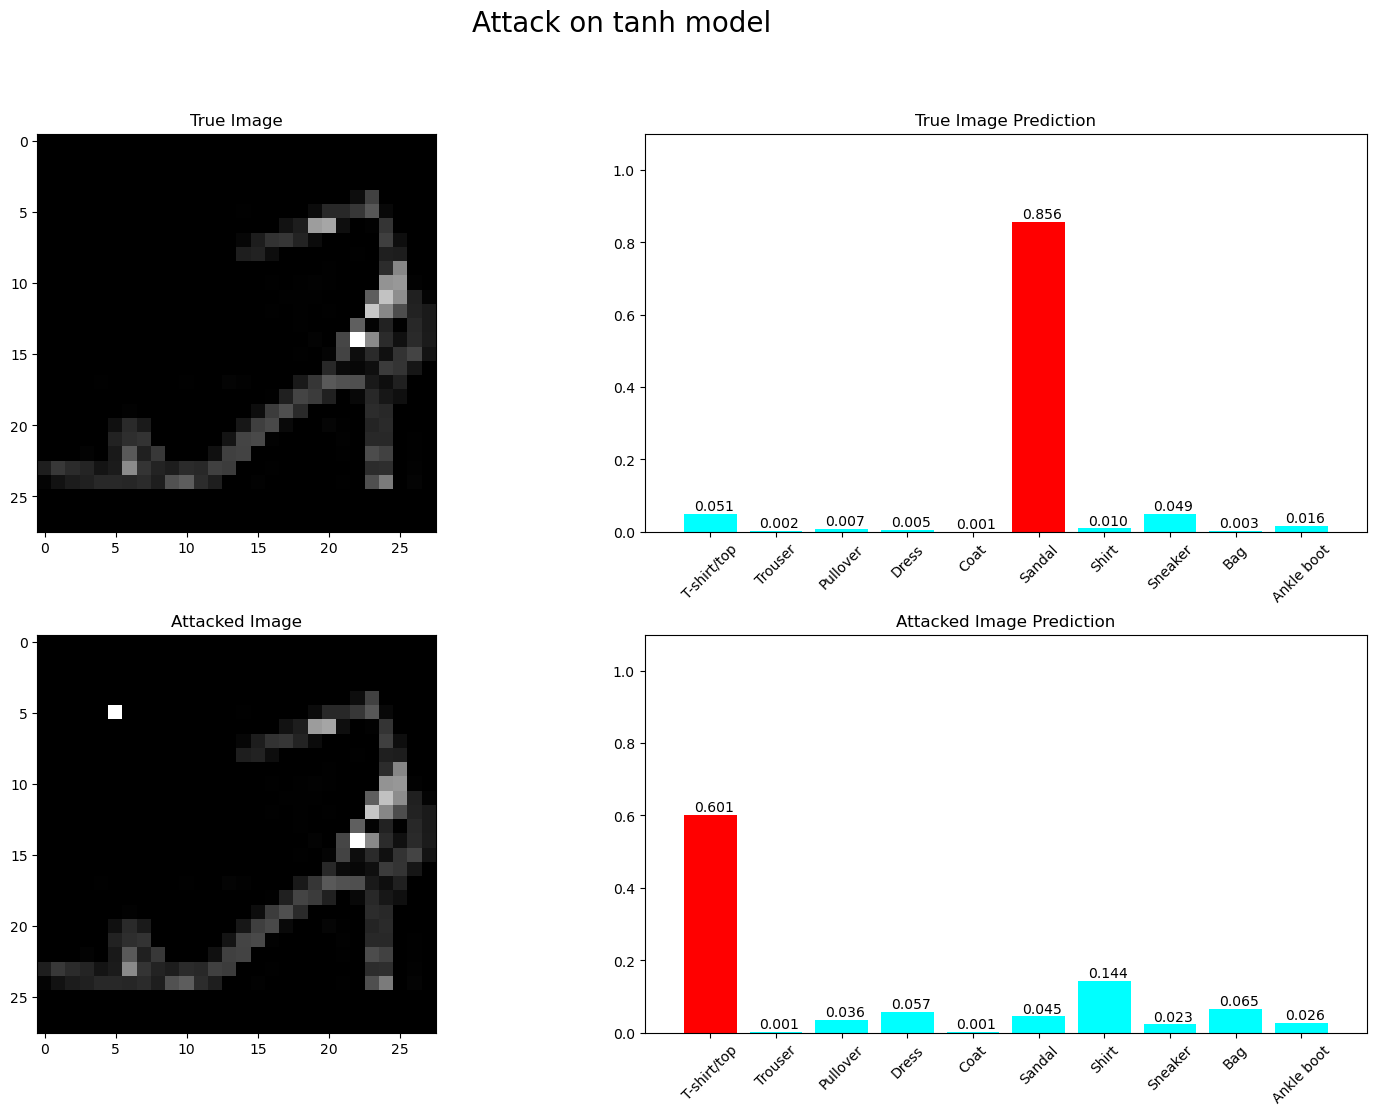

index=7723 value=0.7079980969429016


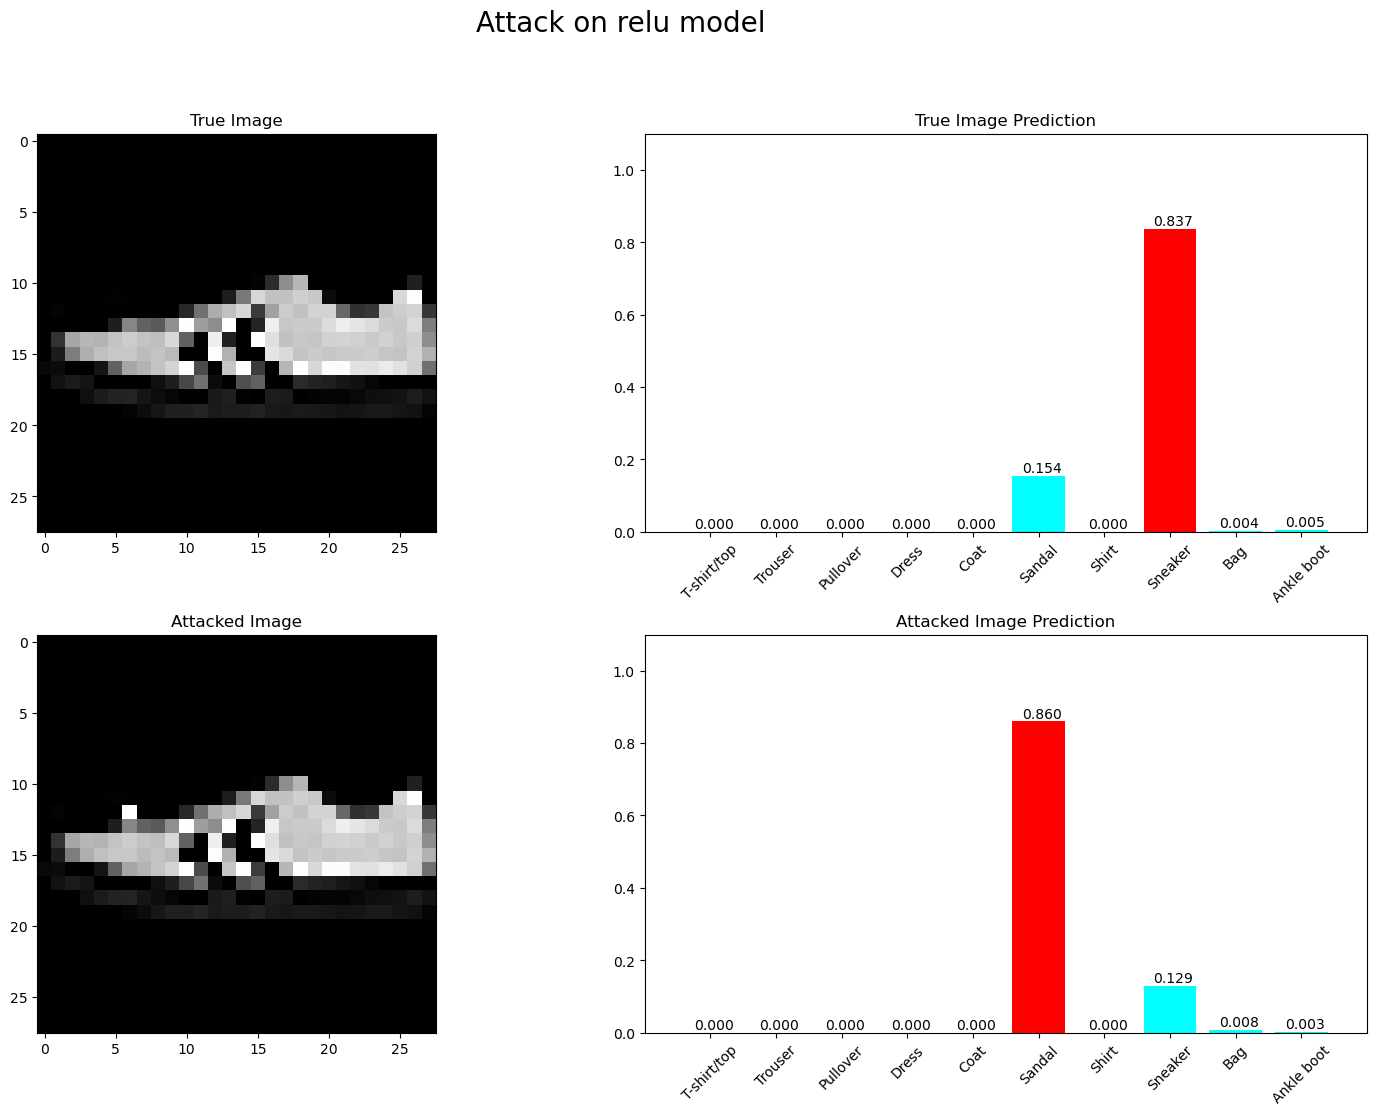

index=5532 value=0.9264162182807922


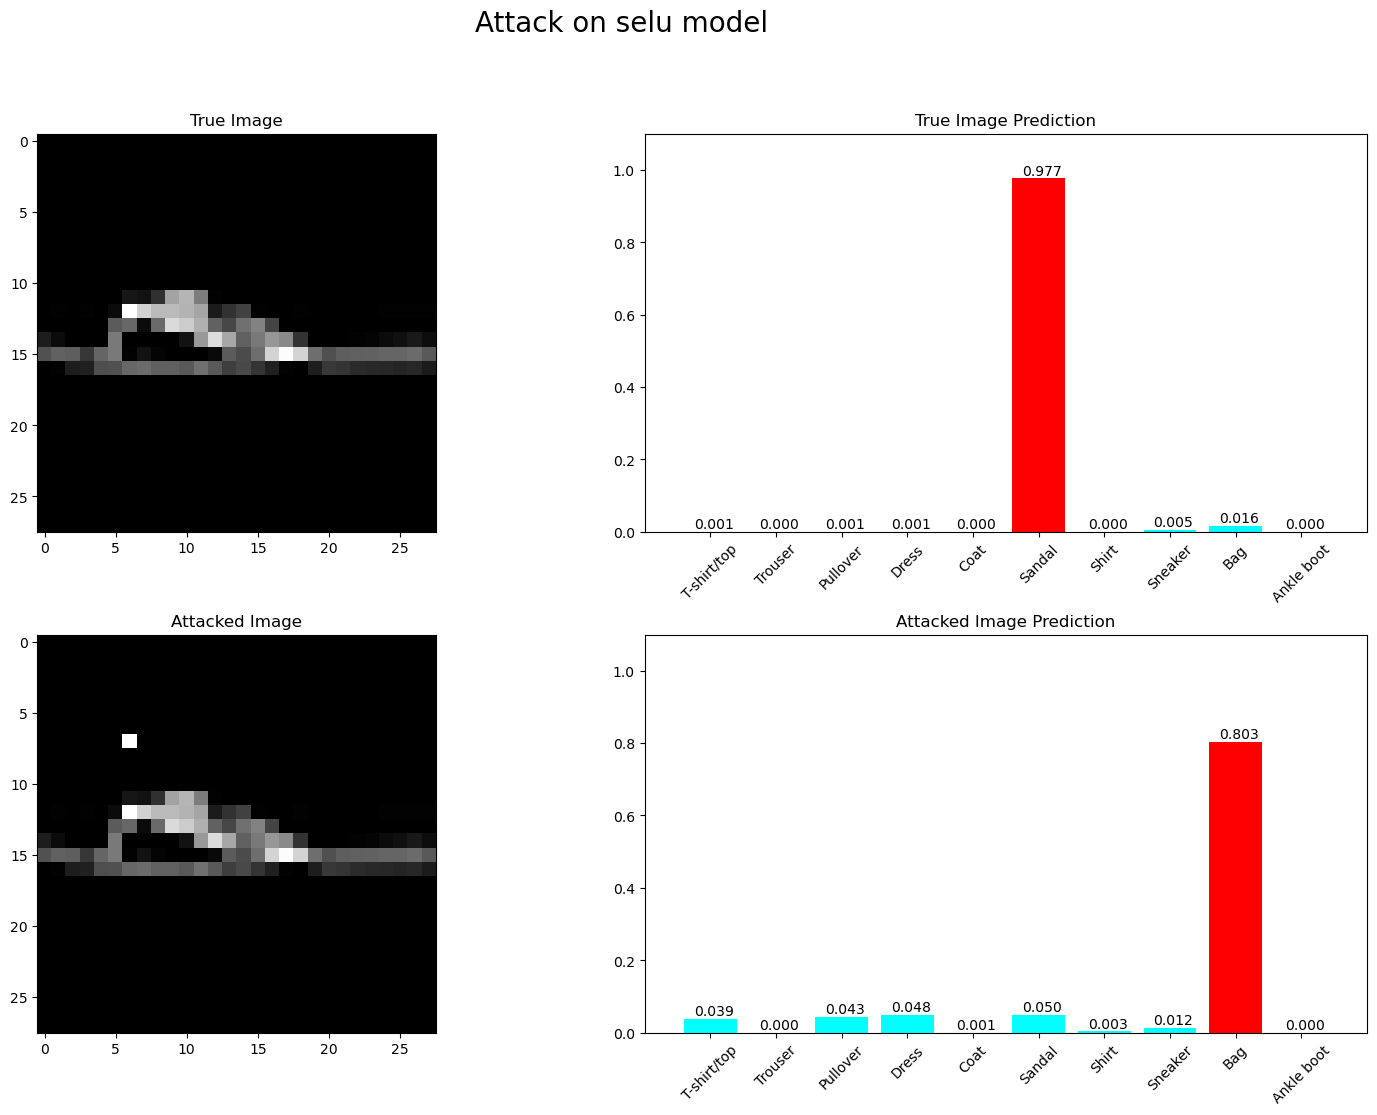

index=5549 value=0.8622840642929077


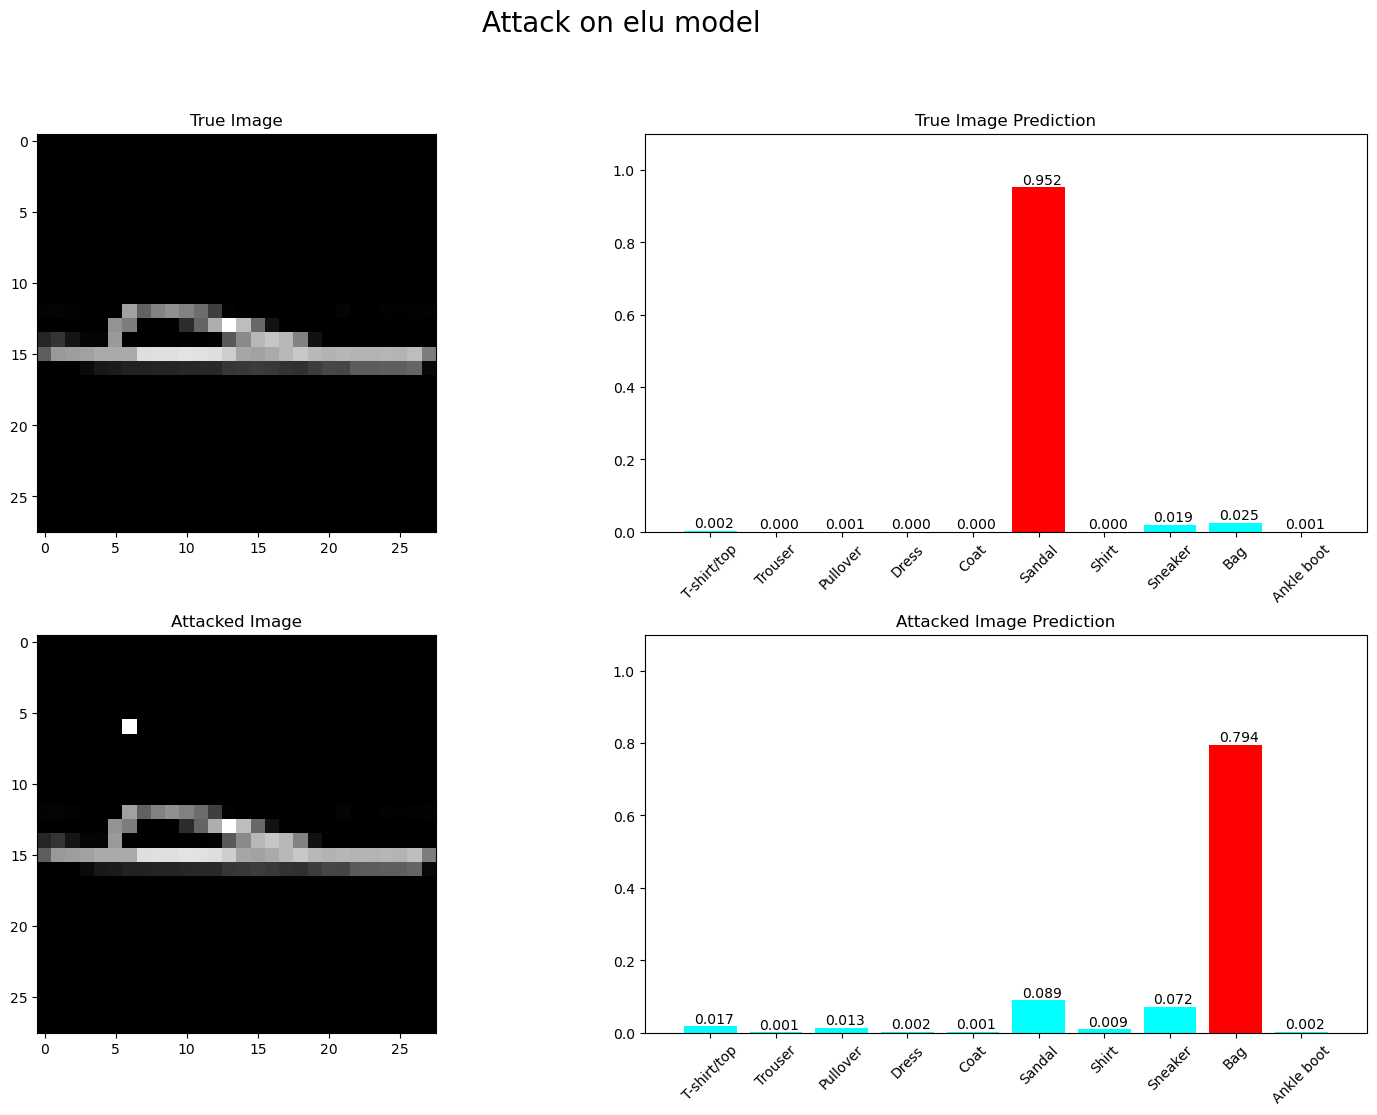

index=2944 value=0.47437411546707153


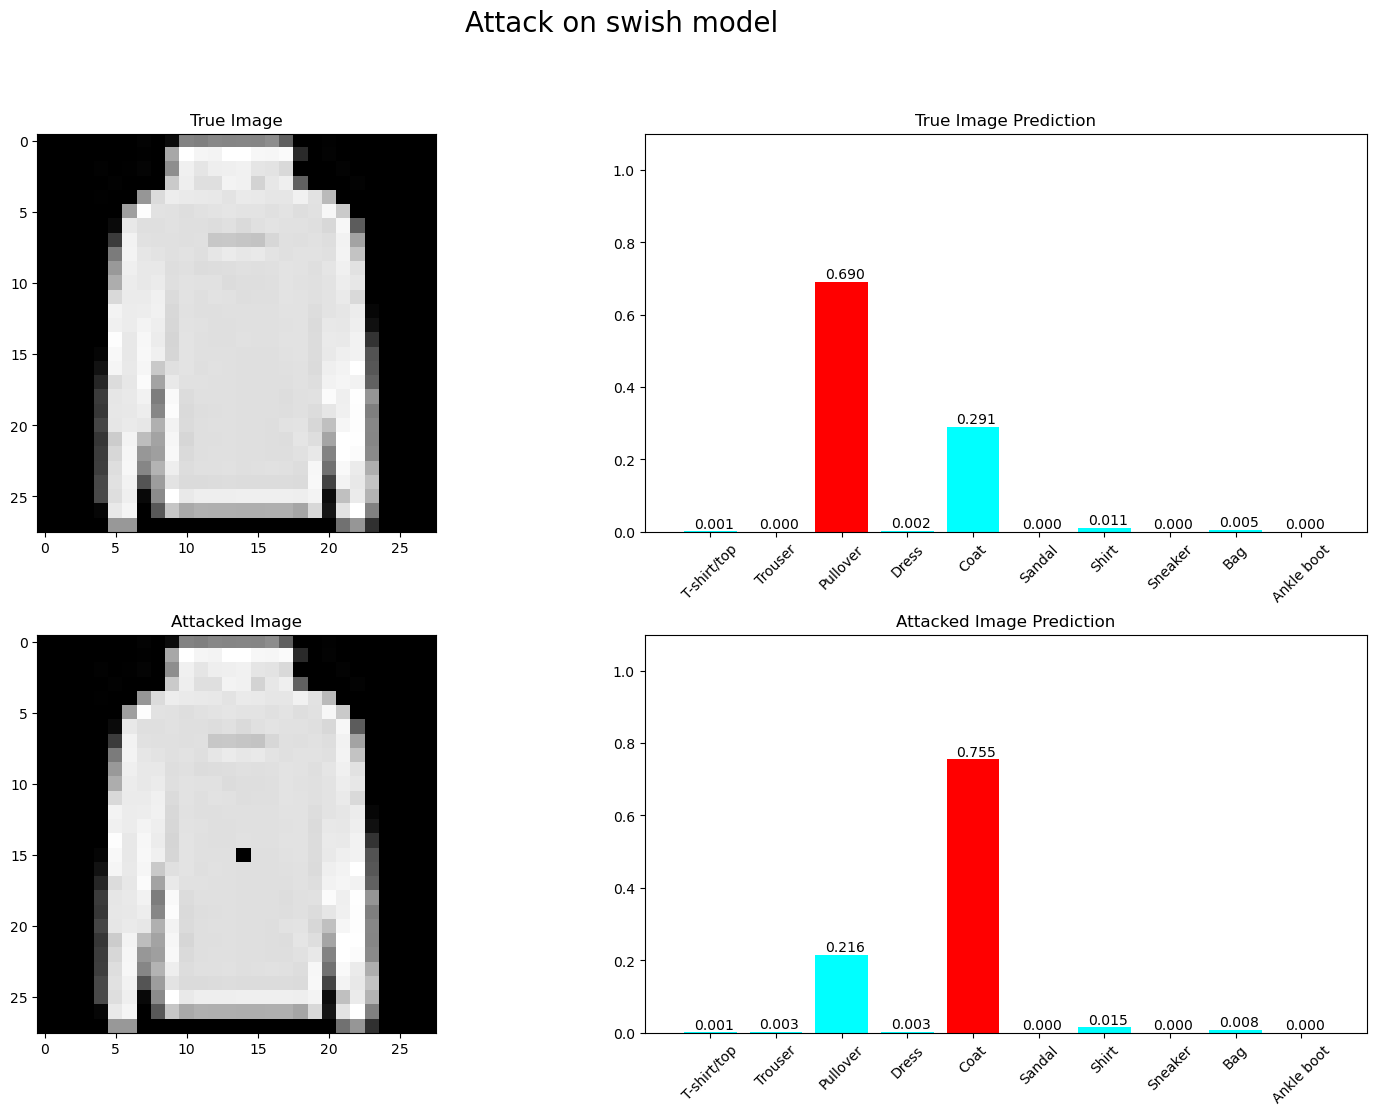

In [3]:
for function, initializer in DEEP_ACTIVATION.items():
    m1 = load_object(SCORES_PATH+"/scores_best_"+function)
    m2 = load_object(SCORES_PATH+"/scores_best_"+function+"_best_attack")
    m = load_model(MODELS_PATH+"/best_"+function+".h5")
    best_attack = 0
    maximum = 0
    for i in range (len(m1.y_true)): # per ogni immagine
        j = np.nonzero(m1.y_true[i])[0][0] # predizione vera
        k = abs(m1.y_pred[i][j] - m2.y_pred[i][j])
        if k >= maximum:
            maximum = k
            best_attack = i

    print(f"index={best_attack} value={maximum}")
    plot_attack(m1.x_test[best_attack], m2.x_test[best_attack], m, function)